# Описание проекта "Определение перспективного тарифа для телеком компании"

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов (500 пользователей): кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов
**Тариф «Смарт»**
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
    •	минута разговора: 3 рубля
    •	сообщение: 3 рубля
    •	1 Гб интернет-трафика: 200 рублей
**Тариф «Ультра»**
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
    •	минута разговора: 1 рубль
    •	сообщение: 1 рубль
    •	1 Гб интернет-трафика: 150 рублей
Минуты и Мб всегда округляются.

**Описание данных**
Таблица users (информация о пользователях):  
•	`user_id` — уникальный идентификатор пользователя  
•	`first_name` — имя пользователя  
•	`last_name` — фамилия пользователя  
•	`age` — возраст пользователя (годы)  
•	`reg_date` — дата подключения тарифа (день, месяц, год)  
•	`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
•	`city` — город проживания пользователя  
•	`tariff` — название тарифного плана  
Таблица calls (информация о звонках):  
•	`id` — уникальный номер звонка  
•	`call_date` — дата звонка  
•	`duration` — длительность звонка в минутах  
•	`user_id` — идентификатор пользователя, сделавшего звонок  
Таблица messages (информация о сообщениях):  
•	`id` — уникальный номер сообщения  
•	`message_date` — дата сообщения  
•	`user_id` — идентификатор пользователя, отправившего сообщение  
Таблица internet (информация об интернет-сессиях):  
•	`id` — уникальный номер сессии  
•	`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)  
•	`session_date` — дата интернет-сессии  
•	`user_id` — идентификатор пользователя  
Таблица tariffs (информация о тарифах):  
•	`tariff_name` — название тарифа  
•	`rub_monthly_fee` — ежемесячная абонентская плата в рублях  
•	`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату  
•	`messages_included` — количество сообщений в месяц, включённых в абонентскую плату  
•	`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
•	`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
•	`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета  
•	`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from matplotlib import pyplot as plt
from math import factorial
from scipy import stats as st

In [2]:
# включу вывод всего из ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Открою файл с данными и изучю общую информацию

In [3]:
df_calls = pd.read_csv('/datasets/calls.csv')

In [4]:
df_internet = pd.read_csv('/datasets/internet.csv')

In [5]:
df_messages = pd.read_csv('/datasets/messages.csv')

In [6]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [7]:
df_users = pd.read_csv('/datasets/users.csv')

In [8]:
all_df = [('df_calls', df_calls), ('df_internet', df_internet), ('df_messages', df_messages), ('df_tariffs', df_tariffs), ('df_users', df_users)]

In [10]:
# выведу данные о всех датафреймах
for i in all_df:
    print ('\033[1m' + 'Датафрейм: ' + i[0] + '\033[0m')
    print('Общая инфо:')
    i[1].info()
    print('Шапка:')
    i[1].head(5)
    print('Размеры датафрейма:')
    i[1].shape
    print('Пропущенные значения:')
    i[1].isna().sum()
    print('')

Датафрейм: df_calls
Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
Шапка:


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Размеры датафрейма:


(202607, 4)

Пропущенные значения:


id           0
call_date    0
duration     0
user_id      0
dtype: int64


Датафрейм: df_internet
Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
Шапка:


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Размеры датафрейма:


(149396, 5)

Пропущенные значения:


Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64


Датафрейм: df_messages
Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
Шапка:


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Размеры датафрейма:


(123036, 3)

Пропущенные значения:


id              0
message_date    0
user_id         0
dtype: int64


Датафрейм: df_tariffs
Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
Шапка:


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Размеры датафрейма:


(2, 8)

Пропущенные значения:


messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64


Датафрейм: df_users
Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
Шапка:


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Размеры датафрейма:


(500, 8)

Пропущенные значения:


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Данные выглядят чистыми, есть пропуски в дате прекращения пользования тарифом, но это нормально, т.к. большинство ещё использует тариф.

## Подготовлю данные

### Исправлю типых данных

In [11]:
# займусь df_calls со звонками
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d') # переведу строку в datetime
df_calls.head(2)
df_calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [12]:
# займусь df_internet с интернетом
df_internet.drop('Unnamed: 0', axis=1, inplace=True) # удалю лишний стобец
df_internet.info()

df_internet['call_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d') # переведу строку в datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [13]:
# займусь df_messages с сообщениями
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d') # переведу строку в datetime
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


### Исправлю ошибки в данных

In [14]:
all_df = [('df_calls', df_calls), ('df_internet', df_internet), ('df_messages', df_messages), ('df_tariffs', df_tariffs), ('df_users', df_users)]

In [15]:
# проверю на пропущенные данные
for i in all_df:
    print('Датафрейм:', i[0])
    print('isna:')
    i[1].isna().sum()
    print('')

Датафрейм: df_calls
isna:


id           0
call_date    0
duration     0
user_id      0
dtype: int64


Датафрейм: df_internet
isna:


id              0
mb_used         0
session_date    0
user_id         0
call_date       0
dtype: int64


Датафрейм: df_messages
isna:


id              0
message_date    0
user_id         0
dtype: int64


Датафрейм: df_tariffs
isna:


messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64


Датафрейм: df_users
isna:


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Пропущенных значений нет, кроме даты прекращения пользования тарифом, но это нормально, т.к. пользователи продолжают им пользоваться.

In [16]:
count_zero_duration = len(df_calls[df_calls['duration'] == 0])
print('Кол-во звонков с нулевым временем: {:.0f}'.format(count_zero_duration))
print('Доля звонков с нулевым временем: {:.1%}'.format(count_zero_duration / 202607))

Кол-во звонков с нулевым временем: 39613
Доля звонков с нулевым временем: 19.6%


Звонков с нулевым временем слишком много, чтобы их можно было просто удалить. Пока оставим их.

Text(0.5, 1.0, 'Распределение длительности звонков')

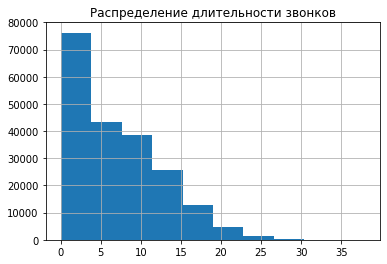

Text(0.5, 1.0, 'Распределение использованного трафика')

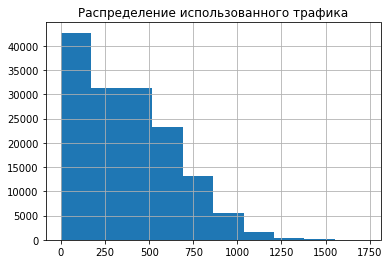

In [17]:
# проверю на наличие некорректных значений
df_calls['duration'].hist()
plt.title('Распределение длительности звонков')
plt.show()
df_internet['mb_used'].hist()
plt.title('Распределение использованного трафика')
plt.show()

Данные не нуждыются в подготовке, пропуски только в 'churn_date'.

### Посчитаю данные для каждого пользователя

#### Подготовлю данные для подсчётов

In [18]:
# добавлю столбец с месяцами
df_calls['calls_month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_internet['internet_month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_messages['message_month'] = pd.DatetimeIndex(df_messages['message_date']).month

In [19]:
# округлю минуты до целых в большую сторону
df_calls['duration_m'] = df_calls['duration'].apply(mt.ceil)
# округлю Мб до целых в большую сторону
df_internet['mb_used_hole'] = df_internet['mb_used'].apply(mt.ceil)

#### Посчитаю данные

In [20]:
# посчитаю кол-во звонков по пользователями и месяцам
count_calls_users = df_calls.pivot_table(index=['user_id', 'calls_month'], values='call_date', aggfunc='count')

In [22]:
# посчитаю израсходованных минут разговора по пользователями и месяцам
duration_calls_users = df_calls.pivot_table(
    index=['user_id', 'calls_month'], values='duration_m', aggfunc='sum'
).reset_index().set_axis(['user_id', 'month', 'duration_m_sum'], axis='columns', inplace=False)

In [23]:
# посчитаю сообщений по пользователями и месяцам
messages_users = df_messages.pivot_table(
    index=['user_id', 'message_month'], values='id', aggfunc='count'
    ).reset_index().set_axis(['user_id', 'month', 'messages'], axis='columns', inplace=False)

In [24]:
duration_calls_users.head(5)

,user_id,month,duration_m_sum
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


In [25]:
# посчитаю израсходованных Мб по пользователями и месяцам
value_traffic_users = df_internet.pivot_table(
    index=['user_id', 'internet_month'], values='mb_used_hole', aggfunc='sum'
).reset_index().set_axis(['user_id', 'month', 'mb_used_sum'], axis='columns', inplace=False)

In [26]:
# создам датафрейм, куда буду складывать агрегированные данные
# сперва заполню его данным о кол-ве звонков
pivot_data = count_calls_users.reset_index()
pivot_data.set_axis(['user_id', 'month', 'calls_count'], axis='columns', inplace=True)

In [27]:
# проверю сводную на пропущенные значения
pivot_data.isna().sum()

user_id        0
month          0
calls_count    0
dtype: int64

In [28]:
pivot_data.head(5)

,user_id,month,calls_count
0,1000,5,22
1,1000,6,43
2,1000,7,47
3,1000,8,52
4,1000,9,58


In [29]:
# через объединение добавлю длительность звонков
pivot_data = pivot_data.merge(duration_calls_users, on = ['user_id', 'month'], how='outer')
pivot_data.head(5)

,user_id,month,calls_count,duration_m_sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [30]:
# проверю сводную на пропущенные значения
pivot_data.isna().sum()

user_id           0
month             0
calls_count       0
duration_m_sum    0
dtype: int64

In [31]:
value_traffic_users.head(5)

,user_id,month,mb_used_sum
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581


In [32]:
# через объединение добавлю данные о использованных Мб
pivot_data = pivot_data.merge(value_traffic_users, on = ['user_id', 'month'], how='outer')
pivot_data.head(5)

,user_id,month,calls_count,duration_m_sum,mb_used_sum
0,1000,5,22.0,159.0,2256.0
1,1000,6,43.0,172.0,23257.0
2,1000,7,47.0,340.0,14016.0
3,1000,8,52.0,408.0,14070.0
4,1000,9,58.0,466.0,14581.0


In [33]:
# проверю сводную на пропущенные значения
pivot_data.isna().sum()

user_id            0
month              0
calls_count       40
duration_m_sum    40
mb_used_sum       11
dtype: int64

In [34]:
# через объединение добавлю данные об отправленных сообщениях
pivot_data = pivot_data.merge(messages_users, on = ['user_id', 'month'], how='outer')
pivot_data.head(5)

,user_id,month,calls_count,duration_m_sum,mb_used_sum,messages
0,1000,5,22.0,159.0,2256.0,22.0
1,1000,6,43.0,172.0,23257.0,60.0
2,1000,7,47.0,340.0,14016.0,75.0
3,1000,8,52.0,408.0,14070.0,81.0
4,1000,9,58.0,466.0,14581.0,57.0


In [35]:
# проверю сводную на пропущенные значения
pivot_data.isna().sum()

user_id             0
month               0
calls_count        40
duration_m_sum     40
mb_used_sum        11
messages          497
dtype: int64

In [36]:
# заполню пропущенные значения нулями, т.к. пользователи не пользовались функциями
pivot_data = pivot_data.fillna(0)

In [37]:
# создам датафрейм-справочник с пользователями и их тарифами
users_tariffs = df_users[['user_id', 'tariff']]

In [38]:
users_tariffs.head(5)

,user_id,tariff
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra


In [39]:
pivot_data = pivot_data.merge(users_tariffs, on = ['user_id'], how = 'outer')
pivot_data.head(5)

,user_id,month,calls_count,duration_m_sum,mb_used_sum,messages,tariff
0,1000,5.0,22.0,159.0,2256.0,22.0,ultra
1,1000,6.0,43.0,172.0,23257.0,60.0,ultra
2,1000,7.0,47.0,340.0,14016.0,75.0,ultra
3,1000,8.0,52.0,408.0,14070.0,81.0,ultra
4,1000,9.0,58.0,466.0,14581.0,57.0,ultra


In [40]:
df_tariffs = df_tariffs.set_index('tariff_name') # сделаю индексом в df_tariffs имя тарифа
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
tariff_name,,,,,,,
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


In [42]:
# напишу функцию, которая будет считать значение выручки для нового столбца ['monthly_profit']
def check_packs(row):
    # выбираю строку в соответствии с тарифом абонента
    t_row = df_tariffs.loc[row['tariff']]
    # считаю выручку по каждой строке (месяцу)
    monthly_profit = np.clip((
        row['duration_m_sum'] - t_row['minutes_included']) * t_row['rub_per_minute'], 0, None
        ) + np.clip((
        row['messages'] - t_row['messages_included']) * t_row['rub_per_message'], 0, None
        ) + np.clip(
        np.ceil((row['mb_used_sum'] - t_row['mb_per_month_included']) / 1024) * t_row['rub_per_gb'], 0, None) + t_row['rub_monthly_fee']
    #rows['monthly_profit'] = monthly_profit
    return monthly_profit


In [43]:
pivot_data['monthly_profit'] = pivot_data.apply(check_packs, axis=1)

In [44]:
pivot_data.head(10)

,user_id,month,calls_count,duration_m_sum,mb_used_sum,messages,tariff,monthly_profit
0,1000,5.0,22.0,159.0,2256.0,22.0,ultra,1950.0
1,1000,6.0,43.0,172.0,23257.0,60.0,ultra,1950.0
2,1000,7.0,47.0,340.0,14016.0,75.0,ultra,1950.0
3,1000,8.0,52.0,408.0,14070.0,81.0,ultra,1950.0
4,1000,9.0,58.0,466.0,14581.0,57.0,ultra,1950.0
5,1000,10.0,57.0,350.0,14717.0,73.0,ultra,1950.0
6,1000,11.0,43.0,338.0,14768.0,58.0,ultra,1950.0
7,1000,12.0,46.0,333.0,9827.0,70.0,ultra,1950.0
8,1001,11.0,59.0,430.0,18452.0,0.0,smart,1350.0
9,1001,12.0,63.0,414.0,14053.0,0.0,smart,550.0


Сделал сводную с средним использованием услуг по пользователям и месяцам, а так же посчитал среднюю месячную выручку. Уже сейчас видно, что у многих пользователей выручка соответствует ежемесячной плате за тариф — скорее всего они не используют весь объём, включённых в пакет услуг.

## Проанализирую данные

Опишу поведение клиентов оператора, исходя из выборки и отвечу на вопросы:  
    • Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?  
    • Посчитайте среднее количество, дисперсию и стандартное отклонение.  
    • Постройте гистограммы. Опишите распределения.

In [47]:
# изучу поведение пользоватетелей по месяцам через средние значения показателей
pivot = pivot_data.groupby(['tariff', 'month']).mean().reset_index().drop('user_id', axis=1)
pivot

,tariff,month,calls_count,duration_m_sum,mb_used_sum,messages,monthly_profit
0,smart,1.0,27.676471,203.852941,8524.441176,18.235294,721.323529
1,smart,2.0,40.189655,298.689655,11611.396552,24.086207,827.603448
2,smart,3.0,54.324675,390.051948,15123.857143,31.857143,1164.623377
3,smart,4.0,51.312500,367.133929,13479.482143,30.741071,963.089286
4,smart,5.0,55.241135,387.361702,15825.198582,33.773050,1204.602837
5,smart,6.0,55.548780,395.640244,15814.768293,33.402439,1208.896341
6,smart,7.0,56.726368,408.353234,15763.512438,33.751244,1228.925373
7,smart,8.0,58.978723,421.468085,16632.174468,33.638298,1329.106383
8,smart,9.0,59.546154,428.611538,16324.526923,33.638462,1255.330769
9,smart,10.0,59.962585,426.136054,16778.564626,33.765306,1369.615646


In [48]:
# посмотрим на показатели по каждому тарифу в среднем в месяц
pivot_tariffs = pivot.groupby('tariff').mean()
pivot_tariffs

,month,calls_count,duration_m_sum,mb_used_sum,messages,monthly_profit
tariff,,,,,,
smart,6.5,53.958072,386.760499,15077.690651,31.413211,1183.606692
ultra,6.5,69.123177,495.934310,18222.784561,43.714983,2047.737868


In [49]:
print('На тарифе "Ультра" пользователи тратят в среднем на {:.0%} больше, чем на "Смарт".'.format(
    pivot_tariffs['monthly_profit'][1] / pivot_tariffs['monthly_profit'][0] - 1
))

На тарифе "Ультра" пользователи тратят в среднем на 73% больше, чем на "Смарт".


In [50]:
pivot.describe().drop('month', axis=1)

,calls_count,duration_m_sum,mb_used_sum,messages,monthly_profit
count,24.000000,24.000000,24.000000,24.000000,24.000000
mean,61.540624,441.347404,16650.237606,37.564097,1615.672280
std,12.969858,92.062584,3205.253617,11.159376,473.479069
min,27.676471,203.852941,8524.441176,18.235294,721.323529
25%,55.471869,394.243170,15603.598614,32.187259,1223.918115
50%,60.732875,431.938681,16811.182313,33.769178,1766.342730
75%,71.594155,510.440194,19261.955029,43.404456,2046.288646
max,83.316547,592.805755,21813.589928,60.611511,2138.848921


In [51]:
pivot.columns

Index(['tariff', 'month', 'calls_count', 'duration_m_sum', 'mb_used_sum',
       'messages', 'monthly_profit'],
      dtype='object')

Text(0.5, 1.0, 'calls_count')

Text(0.5, 0, 'calls_count')

Text(0, 0.5, 'quantity of months')

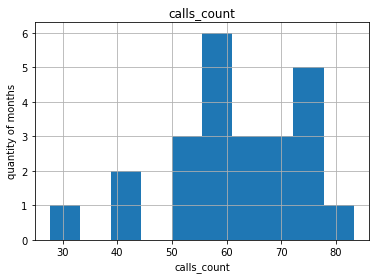

Среднее: 61.54062437108385
Медиана: 60.73287479548782
Дисперсия calls_count : 161.208163502637
Стандартное отклонение calls_count : 12.696777681862317 . Это 21% от среднего


Text(0.5, 1.0, 'duration_m_sum')

Text(0.5, 0, 'duration_m_sum')

Text(0, 0.5, 'quantity of months')

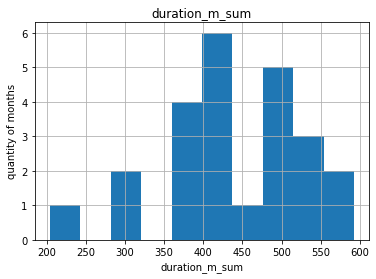

Среднее: 441.34740443407463
Медиана: 431.9386806231743
Дисперсия duration_m_sum : 8122.372747937209
Стандартное отклонение duration_m_sum : 90.12420733597166 . Это 20% от среднего


Text(0.5, 1.0, 'mb_used_sum')

Text(0.5, 0, 'mb_used_sum')

Text(0, 0.5, 'quantity of months')

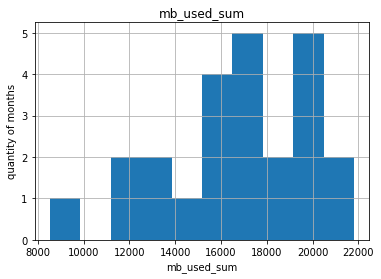

Среднее: 16650.23760628512
Медиана: 16811.18231292517
Дисперсия mb_used_sum : 9845581.969554713
Стандартное отклонение mb_used_sum : 3137.7670355771656 . Это 19% от среднего


Text(0.5, 1.0, 'messages')

Text(0.5, 0, 'messages')

Text(0, 0.5, 'quantity of months')

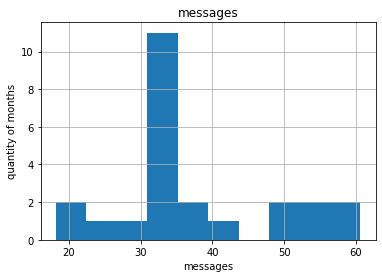

Среднее: 37.56409675127873
Медиана: 33.769177883919525
Дисперсия messages : 119.34285645418885
Стандартное отклонение messages : 10.924415611564257 . Это 29% от среднего


Text(0.5, 1.0, 'monthly_profit')

Text(0.5, 0, 'monthly_profit')

Text(0, 0.5, 'quantity of months')

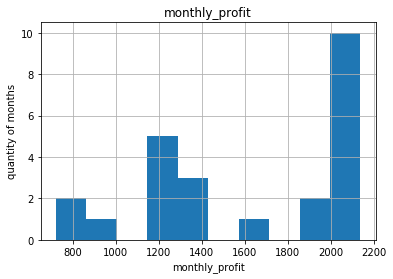

Среднее: 1615.6722797111615
Медиана: 1766.3427299703264
Дисперсия monthly_profit : 214841.49468856212
Стандартное отклонение monthly_profit : 463.50997258803625 . Это 29% от среднего


In [52]:
# цикл для вывода данных по показателям
for column in ['calls_count', 'duration_m_sum', 'mb_used_sum', 'messages', 'monthly_profit']:
    # построю гистрограмму
    fig, ax = plt.subplots()
    pivot[column].hist()
    plt.title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('quantity of months')
    plt.show()
    mean = pivot[column].mean() # посчитаю среднее
    print('Среднее:', mean)
    median = pivot[column].median() # посчитаю медиану
    print('Медиана:', median)
    # посчитаю дисперсию
    variation = np.var(pivot[column])
    print('Дисперсия', column, ':', variation)
    # посчитаю стандартное отклонение
    sqrt = np.sqrt(np.var(pivot[column]))
    print('Стандартное отклонение', column, ':', sqrt, '. Это {:.0%} от среднего'.format(sqrt/mean))

In [53]:
# отключу вывод всего из ячеек
InteractiveShell.ast_node_interactivity = "last_expr"

Проанализирую отдельно каждый тариф, т.к. по ним складываются очень разные картины.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance. 

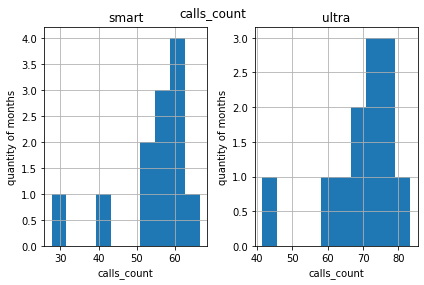

Среднее Smart: 53.95807151748034
Медиана Smart: 56.137574323504424
Дисперсия Smart / calls_count : 100.47056478292212
Стандартное отклонение Smart / calls_count : 10.02350062517692 . Это 19% от среднего

Среднее Ultra: 69.12317722468737
Медиана Ultra: 71.8985911563677
Дисперсия Ultra / calls_count : 106.95554666697056
Стандартное отклонение Ultra / calls_count : 10.34193147661357 . Это 15% от среднего


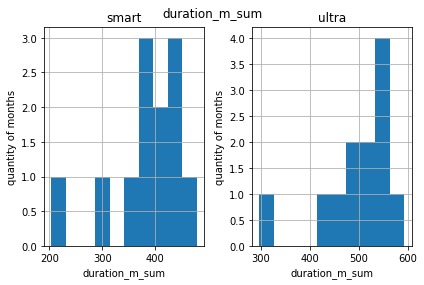

Среднее Smart: 386.76049870568664
Медиана Smart: 401.99673886664243
Дисперсия Smart / duration_m_sum : 4786.647452051491
Стандартное отклонение Smart / duration_m_sum : 69.18560147929257 . Это 18% от среднего

Среднее Ultra: 495.9343101624627
Медиана Ultra: 510.5520295717673
Дисперсия Ultra / duration_m_sum : 5498.637489823082
Стандартное отклонение Ultra / duration_m_sum : 74.1527982602348 . Это 15% от среднего


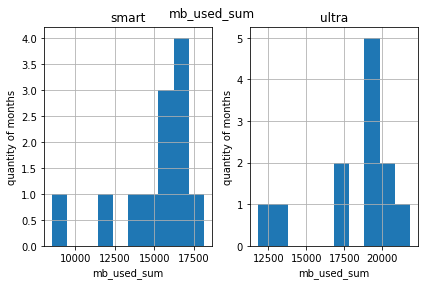

Среднее Smart: 15077.690651369858
Медиана Smart: 15819.983437121606
Дисперсия Smart / mb_used_sum : 6558036.923770799
Стандартное отклонение Smart / mb_used_sum : 2560.866440049305 . Это 17% от среднего

Среднее Ultra: 18222.784561200377
Медиана Ultra: 19301.70136275146
Дисперсия Ultra / mb_used_sum : 8187319.164512123
Стандартное отклонение Ultra / mb_used_sum : 2861.349186050546 . Это 16% от среднего


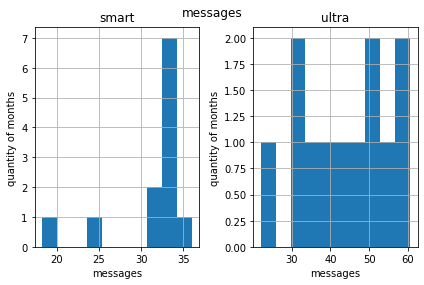

Среднее Smart: 31.413210661085547
Медиана Smart: 33.63837970540098
Дисперсия Smart / messages : 23.874424834598063
Стандартное отклонение Smart / messages : 4.886146215024481 . Это 16% от среднего

Среднее Ultra: 43.71498284147191
Медиана Ultra: 45.082721406319536
Дисперсия Ultra / messages : 139.14448868471572
Стандартное отклонение Ultra / messages : 11.79595221610853 . Это 27% от среднего


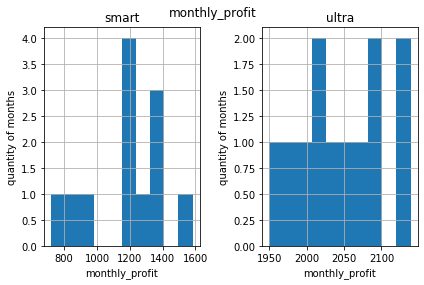

Среднее Smart: 1183.6066915010317
Медиана Smart: 1218.9108572988716
Дисперсия Smart / monthly_profit : 53299.83043656146
Стандартное отклонение Smart / monthly_profit : 230.8675603816211 . Это 20% от среднего

Среднее Ultra: 2047.7378679212914
Медиана Ultra: 2051.5058635394457
Дисперсия Ultra / monthly_profit : 3021.813909831975
Стандартное отклонение Ultra / monthly_profit : 54.97102791318328 . Это 3% от среднего


In [54]:
smart = pivot[pivot['tariff'] == 'smart'] # сводные по тарифу Смарт
ultra = pivot[pivot['tariff'] == 'ultra'] # сводные по тарифу Ультра

# цикл для вывода данных по показателям
for column in ['calls_count', 'duration_m_sum', 'mb_used_sum', 'messages', 'monthly_profit']:
    
    # построю гистрограмму
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    plt.suptitle(column)
    plt.subplot(1,2,1)
    plt.subplot(1,2,1).set_title('smart')
    smart[column].hist()
    ax1.set_xlabel(column)
    ax1.set_ylabel('quantity of months')
    
    plt.subplot(1,2,2)
    plt.subplot(1,2,2).set_title('ultra')
    ultra[column].hist()
    ax2.set_xlabel(column)
    ax2.set_ylabel('quantity of months')
    
    fig.tight_layout() # избавлюсь от перекрытия subplots друг другом
    plt.show() # выведу графики
    
    mean_smart = smart[column].mean() # посчитаю среднее
    print('Среднее Smart:', mean_smart)
    median_smart = smart[column].median() # посчитаю медиану
    print('Медиана Smart:', median_smart)
    # посчитаю дисперсию
    variation_smart = np.var(smart[column])
    print('Дисперсия Smart /', column, ':', variation_smart)
    # посчитаю стандартное отклонение
    sqrt_smart = np.sqrt(np.var(smart[column]))
    print('Стандартное отклонение Smart /', column, ':', sqrt_smart, '. Это {:.0%} от среднего'.format(sqrt_smart/mean_smart))
    print()
    
    mean_ultra = ultra[column].mean()
    print('Среднее Ultra:', mean_ultra)
    median_ultra = ultra[column].median()
    print('Медиана Ultra:', median_ultra)
    variation_ultra = np.var(ultra[column])
    print('Дисперсия Ultra /', column, ':', variation_ultra)
    sqrt_ultra = np.sqrt(np.var(ultra[column]))
    print('Стандартное отклонение Ultra /', column, ':', sqrt_ultra, '. Это {:.0%} от среднего'.format(sqrt_ultra/mean_ultra))
    

_**Выводы:**_  
• **Количество звонков** у большинства пользователей более 50 в месяц, причём на тарифе "Ультра" пользователи разговаривают больше. Отклонение от среднего довольно большое — 21%, т.е. пользователи очень разные в плане частоты звонков.  
• **Длительность звонков** имеет очень похожее на кол-во распределение и аналогичное среднее отклонение. Очень большая часть абонентов разговаривают очень долго, но всё равно не используют пакет в 3000 минут.  
• Среди абонентов тарифа "Смарт" в большинстве месяцев отправляется около 33 **сообщений**.  
• У **средней выручки** по месяцам очень большое отклонение

In [55]:
all_months = ['Jan','Feb','Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

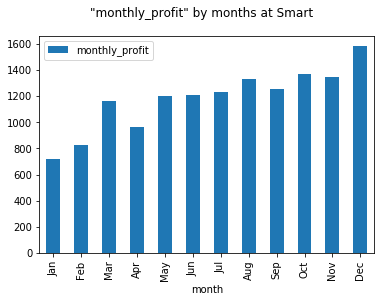

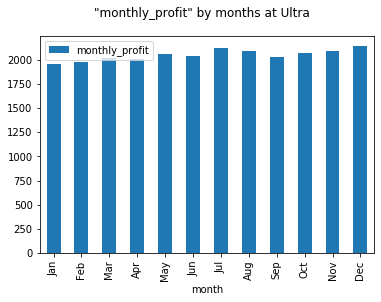

In [56]:
smart.plot.bar(x='month', y='monthly_profit')
plt.suptitle('"monthly_profit" by months at Smart')
plt.xticks(np.arange(12), all_months)
plt.show()

ultra.plot.bar(x='month', y='monthly_profit')
plt.suptitle('"monthly_profit" by months at Ultra')
plt.xticks(np.arange(12), all_months)
plt.show()

Выручка от клиентов тарифа "Смарт" растёт к концу года в 2,5 раза за год. При этом, выручка от абонентов "Ультра" тоже растёт, но едва заметно.

Рассчитаю мат.ожидание, дисперсию и СКО в разрезе тарифов для данные без группировки по месяцам. Из-за того, что в месяцах разное количество наблюдений, средние значения таблиц pivot_data и pivot различаются.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance. 

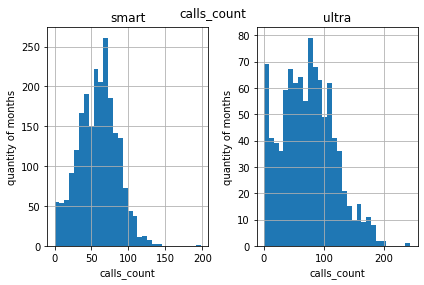

Среднее Smart: 58.46343651861822
Медиана Smart: 60.0
Дисперсия Smart / calls_count : 672.5743697067148
Стандартное отклонение Smart / calls_count : 10.02350062517692 . Это 17% от среднего

Среднее Ultra: 69.12317722468737
Медиана Ultra: 74.0
Дисперсия Ultra / calls_count : 1926.7319291916824
Стандартное отклонение Ultra / calls_count : 43.89455466446473 . Это 64% от среднего


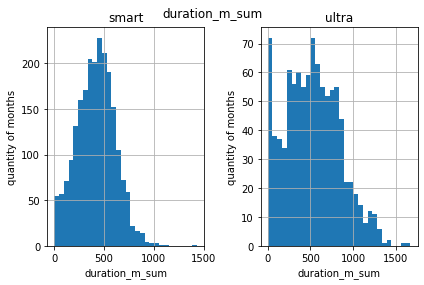

Среднее Smart: 417.9349484073576
Медиана Smart: 422.0
Дисперсия Smart / duration_m_sum : 36203.06665209469
Стандартное отклонение Smart / duration_m_sum : 69.18560147929257 . Это 17% от среднего

Среднее Ultra: 495.9343101624627
Медиана Ultra: 518.0
Дисперсия Ultra / duration_m_sum : 100771.2236172022
Стандартное отклонение Ultra / duration_m_sum : 317.44483554974113 . Это 64% от среднего


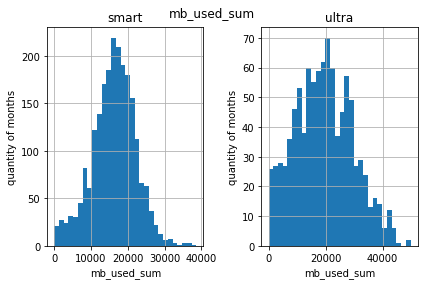

Среднее Smart: 16229.188425302826
Медиана Smart: 16531.0
Дисперсия Smart / mb_used_sum : 34530412.73703965
Стандартное отклонение Smart / mb_used_sum : 2560.866440049305 . Это 16% от среднего

Среднее Ultra: 18222.784561200377
Медиана Ultra: 19324.0
Дисперсия Ultra / mb_used_sum : 101832133.10806875
Стандартное отклонение Ultra / mb_used_sum : 10091.190866695008 . Это 55% от среднего


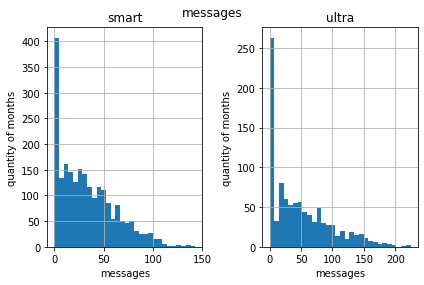

Среднее Smart: 33.384028712427096
Медиана Smart: 28.0
Дисперсия Smart / messages : 796.455482917076
Стандартное отклонение Smart / messages : 4.886146215024481 . Это 15% от среднего

Среднее Ultra: 43.71498284147191
Медиана Ultra: 38.0
Дисперсия Ultra / messages : 2282.946075394882
Стандартное отклонение Ultra / messages : 47.78018496610161 . Это 109% от среднего


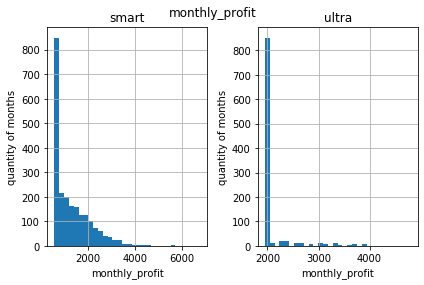

Среднее Smart: 1294.6393001345896
Медиана Smart: 1038.0
Дисперсия Smart / monthly_profit : 673628.974426787
Стандартное отклонение Smart / monthly_profit : 230.8675603816211 . Это 18% от среднего

Среднее Ultra: 2047.7378679212914
Медиана Ultra: 1950.0
Дисперсия Ultra / monthly_profit : 143345.5641732588
Стандартное отклонение Ultra / monthly_profit : 378.61004235658993 . Это 18% от среднего


In [59]:
smart_data = pivot_data[pivot_data['tariff'] == 'smart'] # сводные по тарифу Смарт
ultra_data = pivot_data[pivot_data['tariff'] == 'ultra'] # сводные по тарифу Ультра

# цикл для вывода данных по показателям
for column in ['calls_count', 'duration_m_sum', 'mb_used_sum', 'messages', 'monthly_profit']:
    
    # построю гистрограмму
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    plt.suptitle(column)
    plt.subplot(1,2,1)
    plt.subplot(1,2,1).set_title('smart')
    smart_data[column].hist(bins=30)
    ax1.set_xlabel(column)
    ax1.set_ylabel('quantity of months')
    
    plt.subplot(1,2,2)
    plt.subplot(1,2,2).set_title('ultra')
    ultra_data[column].hist(bins=30)
    ax2.set_xlabel(column)
    ax2.set_ylabel('quantity of months')
    
    fig.tight_layout() # избавлюсь от перекрытия subplots друг другом
    plt.show() # выведу графики
    
    mean_smart = smart_data[column].mean() # посчитаю среднее
    print('Среднее Smart:', mean_smart)
    median_smart = smart_data[column].median() # посчитаю медиану
    print('Медиана Smart:', median_smart)
    # посчитаю дисперсию
    variation_smart = np.var(smart_data[column])
    print('Дисперсия Smart /', column, ':', variation_smart)
    # посчитаю стандартное отклонение
    sqrt_smart = np.sqrt(np.var(smart[column]))
    print('Стандартное отклонение Smart /', column, ':', sqrt_smart, '. Это {:.0%} от среднего'.format(sqrt_smart/mean_smart))
    print()
    
    mean_ultra = ultra[column].mean()
    print('Среднее Ultra:', mean_ultra)
    median_ultra = ultra_data[column].median()
    print('Медиана Ultra:', median_ultra)
    variation_ultra = np.var(ultra_data[column])
    print('Дисперсия Ultra /', column, ':', variation_ultra)
    sqrt_ultra = np.sqrt(np.var(ultra_data[column]))
    print('Стандартное отклонение Ultra /', column, ':', sqrt_ultra, '. Это {:.0%} от среднего'.format(sqrt_ultra/mean_ultra))
    

Предположение подтвердилось. Так данные выглядят более полными без выбросов.

In [56]:
def pack_mimutes_used(row):
    t_row = df_tariffs.loc[row['tariff']]
    used = (row['duration_m_sum'] - t_row['minutes_included']) / t_row['minutes_included']
    return used

def pack_messages_used(row):
    t_row = df_tariffs.loc[row['tariff']]
    used = (row['messages'] - t_row['messages_included']) / t_row['messages_included']
    return used

def pack_mb_used(row):
    t_row = df_tariffs.loc[row['tariff']]
    used = (row['mb_used_sum'] - t_row['mb_per_month_included']) / t_row['mb_per_month_included']
    return used

In [57]:
pivot_data['minutes_used'] = pivot_data.apply(pack_mimutes_used, axis=1)
pivot_data['messages_used'] = pivot_data.apply(pack_messages_used, axis=1)
pivot_data['mb_used'] = pivot_data.apply(pack_mb_used, axis=1)

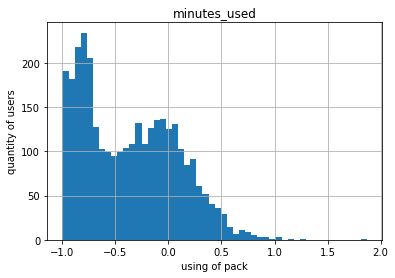

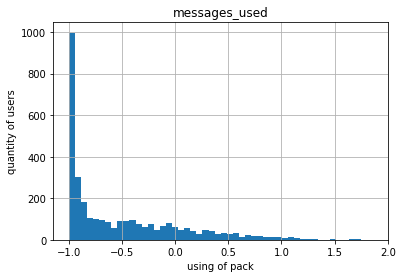

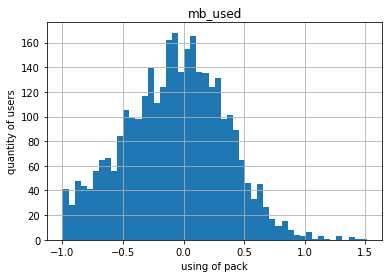

In [58]:
pivot_data['minutes_used'].hist(bins=50)
plt.title('minutes_used')
plt.xlabel('using of pack')
plt.ylabel('quantity of users')
plt.show()
pivot_data['messages_used'].hist(bins=50)
plt.title('messages_used')
plt.xlabel('using of pack')
plt.ylabel('quantity of users')
plt.show()
pivot_data['mb_used'].hist(bins=50)
plt.title('mb_used')
plt.xlabel('using of pack')
plt.ylabel('quantity of users')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

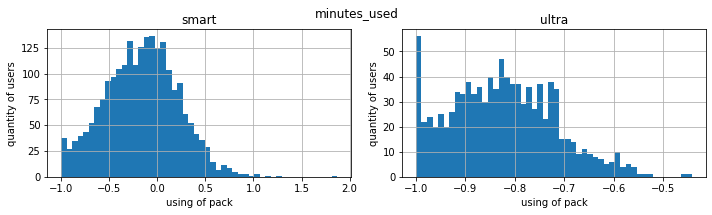

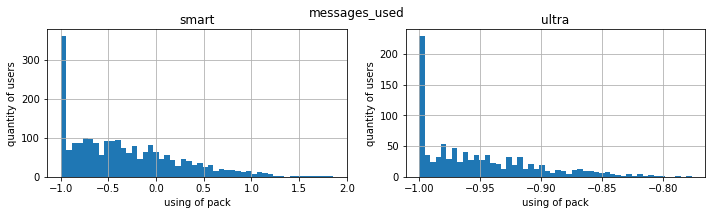

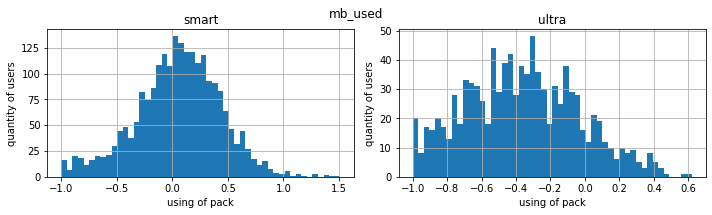

In [59]:
for column in ['minutes_used', 'messages_used', 'mb_used']:

    fig = plt.figure(figsize=(10, 3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    plt.suptitle(column)
    plt.subplot(1,2,1)
    plt.subplot(1,2,1).set_title('smart')
    pivot_data[pivot_data['tariff'] == 'smart'][column].hist(bins=50)
    ax1.set_xlabel('using of pack')
    ax1.set_ylabel('quantity of users')
    
    plt.subplot(1,2,2)
    plt.subplot(1,2,2).set_title('ultra')
    pivot_data[pivot_data['tariff'] == 'ultra'][column].hist(bins=50)
    ax2.set_xlabel('using of pack')
    ax2.set_ylabel('quantity of users')
    
    fig.tight_layout() # избавлюсь от перекрытия subplots друг другом
    plt.show() # выведу графики

Довольно сильно отличается поведение пользователей тарифов в части использования пакетов минут, сообщений и трафика.  
Нормально распределено использование минут и интернета на тарифе "Смарт" около значения пакета, т.е. большинство абонентов используют объём минут и трафика примерно равный размеру включённого пакета.  
У абонентов "Ультра" использование минут и интернета смещено в меньшую сторону, т.к. пользователи не успевают расходовать весь объём услуг, включённых в пакеты.  
Интересно распределение сообщений в обоих тарифах: огромная часть пользователей практически не пользуется сообщениями или пользуется крайне мало.

## Проверю гипотезы

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [60]:
pivot_tariffs

,month,calls_count,duration_m_sum,mb_used_sum,messages,monthly_profit
tariff,,,,,,
smart,6.5,53.958072,386.760499,15077.690651,31.413211,1183.606692
ultra,6.5,69.123177,495.934310,18222.784561,43.714983,2047.737868


In [61]:
sample_1 = pivot_data[pivot_data['tariff'] == 'smart']
sample_2 = pivot_data[pivot_data['tariff'] == 'ultra']

In [62]:
# проверю на NaN
print(sample_1.isna().sum())
print(sample_2.isna().sum())

user_id           0
month             1
calls_count       1
duration_m_sum    1
mb_used_sum       1
messages          1
tariff            0
monthly_profit    1
minutes_used      1
messages_used     1
mb_used           1
dtype: int64
user_id           0
month             1
calls_count       1
duration_m_sum    1
mb_used_sum       1
messages          1
tariff            0
monthly_profit    1
minutes_used      1
messages_used     1
mb_used           1
dtype: int64


In [63]:
sample_1.dropna(inplace=True)
sample_2.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
sample_1_list = sample_1['monthly_profit'].to_list()
sample_2_list = sample_2['monthly_profit'].to_list()
print(sample_1_list[:5]) # проверю полученные списки
print(sample_2_list[:5])

[1350.0, 550.0, 550.0, 1150.0, 1550.0]
[1950.0, 1950.0, 1950.0, 1950.0, 1950.0]


**Нулевая гипотеза** будет звучать так:  
"средняя выручка пользователей тарифов «Ультра» и «Смарт» идентичная".  
Нулевую гипотезу формулируем так, чтобы она звучала положительно и проверялась через знак равенства.  
**Альтернативная гипотеза:**  
"средняя выручка пользователей тарифов "Смарт" и "Ультра" не равны".  
**Пороговое значение alpha** выберу равное 5% как общепринятый вариант.

In [66]:
result_tariffs = st.ttest_ind(sample_1_list, sample_2_list, equal_var = True)
print('p-значение: ', result_tariffs.pvalue)
alpha = 0.05
if result_tariffs.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  2.9776448000521676e-158
Отвергаем нулевую гипотезу


In [67]:
result_tariffs

Ttest_indResult(statistic=-28.37640735783545, pvalue=2.9776448000521676e-158)

Скорее всего, средняя выручка от пользователей на тарифах отличается, т.к. нам пришлось отвергнуть нулевую гипотезу.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

**Нулевая гипотеза:**  
средняя выручка пользователей из Москвы соответствует выручке пользователей из других регионов.  
**Альтернативная гипотеза:**  
средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов.

In [68]:
array_id_msk = df_users[df_users['city'] == 'Москва']['user_id'].unique()
array_id_reg = df_users[df_users['city'] != 'Москва']['user_id'].unique()

In [69]:
sample_moscow = pivot_data[pivot_data['user_id'].isin(array_id_msk)]
sample_regions = pivot_data[pivot_data['user_id'].isin(array_id_reg)]

In [70]:
print(sample_moscow.isna().sum())
print(sample_regions.isna().sum())

user_id           0
month             0
calls_count       0
duration_m_sum    0
mb_used_sum       0
messages          0
tariff            0
monthly_profit    0
minutes_used      0
messages_used     0
mb_used           0
dtype: int64
user_id           0
month             2
calls_count       2
duration_m_sum    2
mb_used_sum       2
messages          2
tariff            0
monthly_profit    2
minutes_used      2
messages_used     2
mb_used           2
dtype: int64


In [71]:
# удолю пустые значения в выборке регионов, их всего 2
sample_regions.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
# выберу значения выручку и сложу в множество
sample_msk_list = sample_moscow['monthly_profit'].to_list()
sample_reg_list = sample_regions['monthly_profit'].to_list()

In [73]:
result_area = st.ttest_ind(sample_msk_list, sample_reg_list, equal_var = True)
print('p-значение:', result_area.pvalue)
if result_area.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


Похоже, что средняя выручка ползьзователей из Москвы примерно соответствует выручке от пользователей из других регионов.

## Общие выводы

- Пользователи разных тарифов используют разное количество доступных в пакетах минут, сообщений, трафика, совершают разное кол-во звонков. При этом, многие пользователи не используют доступные лимиты, а часть платит за дополнительные пакеты.  
- Средняя месячная выручка на тарифах разная: на "Ультра" она на 75% больше, чем на "Смарт".  
- Пользователи "Ультра" как правило не используют весь объём услуг, включённых в пакеты минут, сообщений и интернета. Абоненты "Смарт" наоборот, достаточно рационально используют пакеты минут и интернета. А вот с использованием сообщений у обоих групп сложности — похоже интернет-мессенджеры "берут своё" и люди всё реже отправляют старые добрые сообщения.

Если мы смотрим **со стороны компании, больше выручки приносит тариф "Ультра"**, т.к. за него пользователи платят больше, а используют не весь объём трафика. Чтобы сделать однозначный вывод, не хватает данных о себестоимости услуг для компании.
    
**Для пользователей выглядит более выгодным тариф "Смарт"**, т.к. они в данном случае не платят на неиспользованные услуги (минуты, сообщения, интернет) и в среднем платят меньше абонентов "Ультра". Но у них и потребности скромнее. Уверен, что если примерить расходы услуг абонентов "Ультра" с условиями тарифа "Смарт", их расходы окажутся значительно больше в среднем (но для части абонентов "Ультра" есть смысл перейти на "Смарт", тут нужно отдельно поисследовать и можно будет сделать рекомендацию при условии, что роскошные условия тарифа не стимулируют использовать услуги больше необходимого).